In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
import numpy as np
import faiss
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Subset

/home/jme3qd/.conda/envs/dsvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(518),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

if using the `dsvenv` virtual environment, you'll need to run the following in command line to use `timm` and `faiss`

```
source activate /home/COMPUTING_ID/.conda/dsvenv
pip install timm faiss
```

In [13]:
from torch.utils.data import Dataset
from PIL import Image
import os

class UnlabeledImageFolder(Dataset):
    """Loads all images in a directory (recursively if desired) without requiring class subfolders."""
    def __init__(self, root_dir, transform=None, extensions=(".jpg", ".jpeg", ".png")):
        self.root_dir = root_dir
        self.transform = transform
        self.extensions = extensions

        # collect image paths
        self.image_paths = []
        for dirpath, _, filenames in os.walk(root_dir):
            for f in filenames:
                if f.lower().endswith(extensions):
                    self.image_paths.append(os.path.join(dirpath, f))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, path  # no label, just path


In [14]:
train_dataset = datasets.ImageFolder("/scratch/jme3qd/data/plantclef2025/images_max_side_800", transform=transform)

n_samples = 20000
indices = np.random.choice(len(train_dataset), n_samples, replace=False)
train_subset = Subset(train_dataset, indices)

In [ ]:
#train_loader = DataLoader(train_subset, batch_size=32, shuffle=False, num_workers=4)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4)

In [16]:
from pathlib import Path
quadrat_path = "/scratch/jme3qd/data/plantclef2025/data/PlantCLEF/PlantCLEF2025/DataOut/test/package/images"
quadrat_paths = list(Path(quadrat_path).glob("*.jpg"))

quadrat_dataset = UnlabeledImageFolder(quadrat_path, transform=transform)
quadrat_loader = DataLoader(quadrat_dataset, batch_size=32, shuffle=False, num_workers=4)

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = timm.create_model("timm/vit_base_patch14_reg4_dinov2.lvd142m", pretrained=True)
#model = timm.create_model("vit_base_patch16_224", pretrained=True)
checkpoint_path = '/home/jme3qd/Downloads/model_best.pth.tar'
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False) # Load to CPU first

if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint # Assume the checkpoint itself is the state_dict

# 3. Load the state dictionary into the model
model.load_state_dict(state_dict,strict=False)

model.eval().to(device)
for p in model.parameters():
    p.requires_grad = False


In [25]:
def extract_embeddings(dataloader):
    all_embs, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader):
            imgs = imgs.to(device)
            feats = model.forward_features(imgs)
            if feats.ndim == 3:
                cls_embs = feats[:, 0, :]  # [CLS] token
            else:
                cls_embs = feats
            all_embs.append(cls_embs.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_embs), np.concatenate(all_labels)

train_embs, train_labels = extract_embeddings(train_loader)

  0%|          | 0/625 [00:00<?, ?it/s]/home/jme3qd/.conda/envs/dsvenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  1%|▏         | 9/625 [00:11<12:49,  1.25s/it]


KeyboardInterrupt: 

In [ ]:
import numpy as np
from tqdm import tqdm

def extract_unlabeled_embeddings(dataloader, model, device):
    all_embs, all_paths = [], []
    with torch.no_grad():
        for imgs, paths in tqdm(dataloader):
            imgs = imgs.to(device)
            feats = model.forward_features(imgs)
            cls_embs = feats[:, 0, :] if feats.ndim == 3 else feats
            all_embs.append(cls_embs.cpu().numpy())
            all_paths.extend(paths)
    return np.concatenate(all_embs), all_paths

quadrat_embs, quadrat_paths = extract_unlabeled_embeddings(quadrat_loader, model, device)
np.save("quadrat_embs.npy", quadrat_embs)


100%|██████████| 66/66 [07:41<00:00,  6.99s/it]


In [20]:
faiss.normalize_L2(quadrat_embs)
faiss.normalize_L2(train_embs)
index = faiss.IndexFlatIP(train_embs.shape[1])
index.add(train_embs)
D, I = index.search(quadrat_embs, k=5)

In [21]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(train_embs, train_labels, metric='cosine')
print(f"Silhouette score: {sil_score:.3f}")


Silhouette score: -0.055


In [22]:
D_train, I_train = index.search(train_embs, k=5)
purity = np.mean([
    np.mean(train_labels[i] == train_labels[nbrs]) 
    for i, nbrs in enumerate(I_train)
])
print(f"Neighborhood purity (k=5): {purity:.3f}")


Neighborhood purity (k=5): 0.433


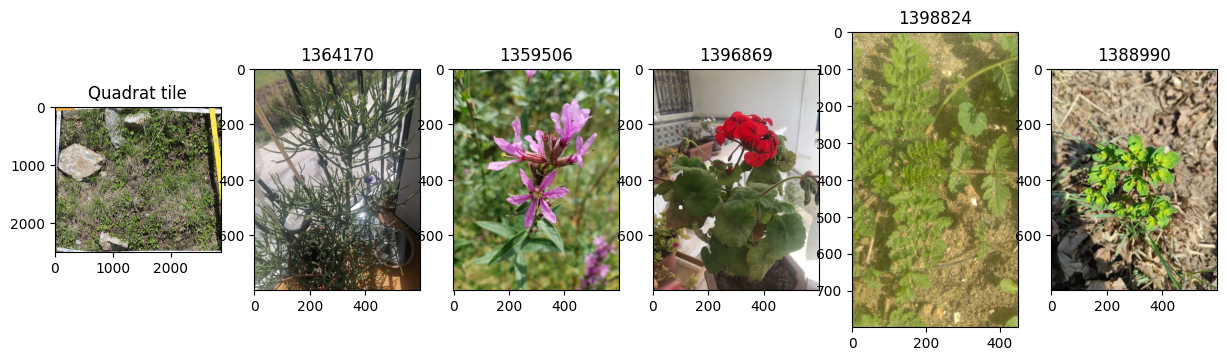

In [26]:
from matplotlib import pyplot as plt
import random
from PIL import Image

k = 5
idx = random.randint(0, len(quadrat_paths)-1)
nbrs = I[idx]
fig, axes = plt.subplots(1, k+1, figsize=(15, 4))
axes[0].imshow(Image.open(quadrat_paths[idx]))
axes[0].set_title("Quadrat tile")
for j, n in enumerate(nbrs):
    axes[j+1].imshow(Image.open(train_dataset.samples[n][0]))
    axes[j+1].set_title(train_dataset.classes[train_labels[n]])
plt.savefig(f"quadrat_{idx}.png")
